In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import sys
import os
from pathlib import Path

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import healpy as hp
import pymaster as nmt
import numpy as np

In [4]:
from cibinfo import fields

# Load data

## Generate fields

In [5]:
nside = 1024
npix = hp.nside2npix(nside)
lmax = 2048

fwhm = 10./60.
pixfunc = hp.pixwin(nside)[:lmax]
beamfunc = hp.gauss_beam(fwhm=np.radians(fwhm), lmax=lmax-1)
windowfunc = pixfunc * beamfunc

We generate a joint realization of the CIB and CMB lensing convergence. Here, map $X$ corresponds to the CIB, $Y$ corresponds to $\kappa$.

In [6]:
sim = fields.CIBxKappa(
    545, unit='MJy^2/sr',
    nside=nside,
    pixwin_cib=True, fwhm_cib=fwhm,
    add_cib_noise=False, add_lensing_noise=True,
)

In [7]:
sim.generate()

/Users/dlenz/anaconda/lib/python3.6/site-packages/healpy/sphtfunc.py:295: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning)


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 4.246609 arcmin (0.001235 rad) 
-> fwhm is 10.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


(array([-0.07333559, -0.08799307, -0.08618065, ...,  0.02138772,
         0.03301563,  0.02965096]),
 array([ 1.77068935,  0.31620042, -0.4153198 , ..., -1.03621336,
        -0.98558969,  0.1038227 ]))

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10, 10))

ax1.set_title('CIBxCIB')
ax1.loglog(
    sim.Cl_XX,
)

ax2.set_title('KappaXKappa')
ax2.loglog(
    sim.Cl_YY,
)

ax3.set_title('CIBxKappa')
ax3.loglog(
    sim.Cl_XY,
)

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel(r'$\ell$')
    ax.set_ylabel(r'$C_{\ell}$')

Sigma is 4.246609 arcmin (0.001235 rad) 
-> fwhm is 10.000000 arcmin


/Users/dlenz/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2223: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.     You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplotswith the constrained_layout=True kwarg.
  warnings.warn("Calling figure.constrained_layout, but figure "


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


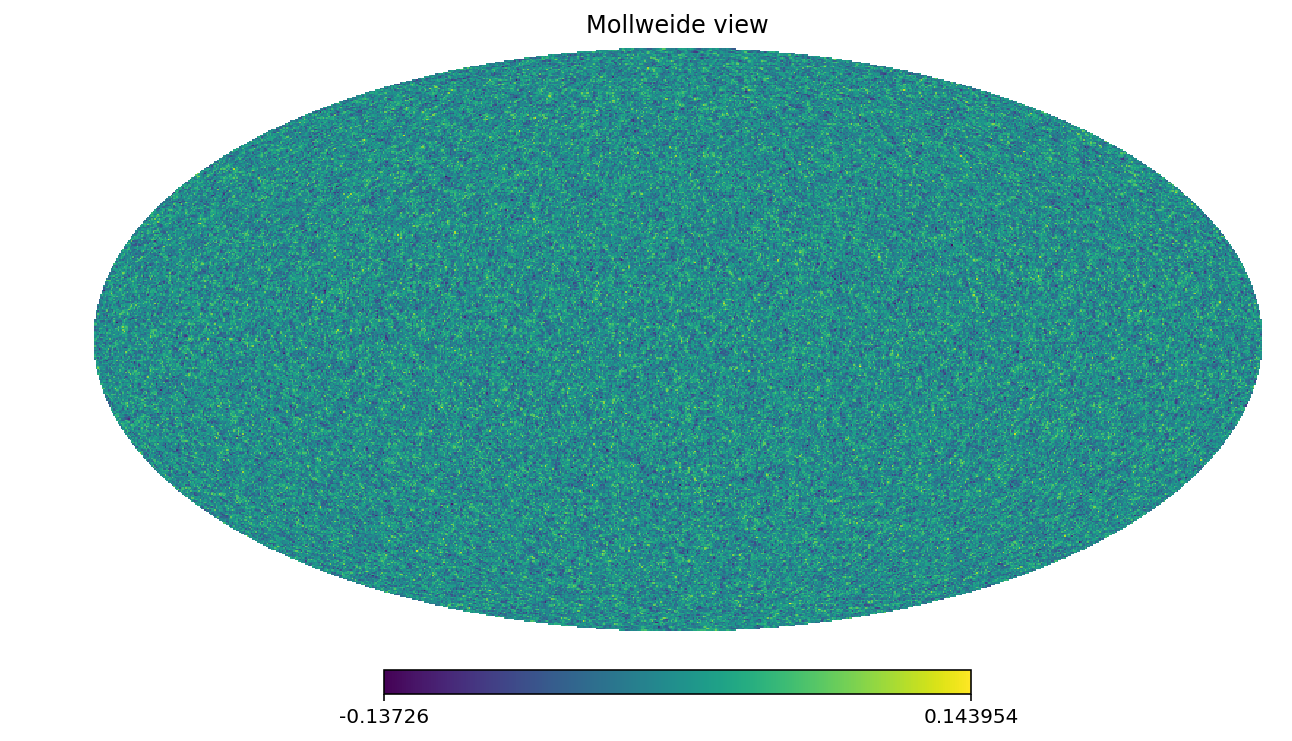

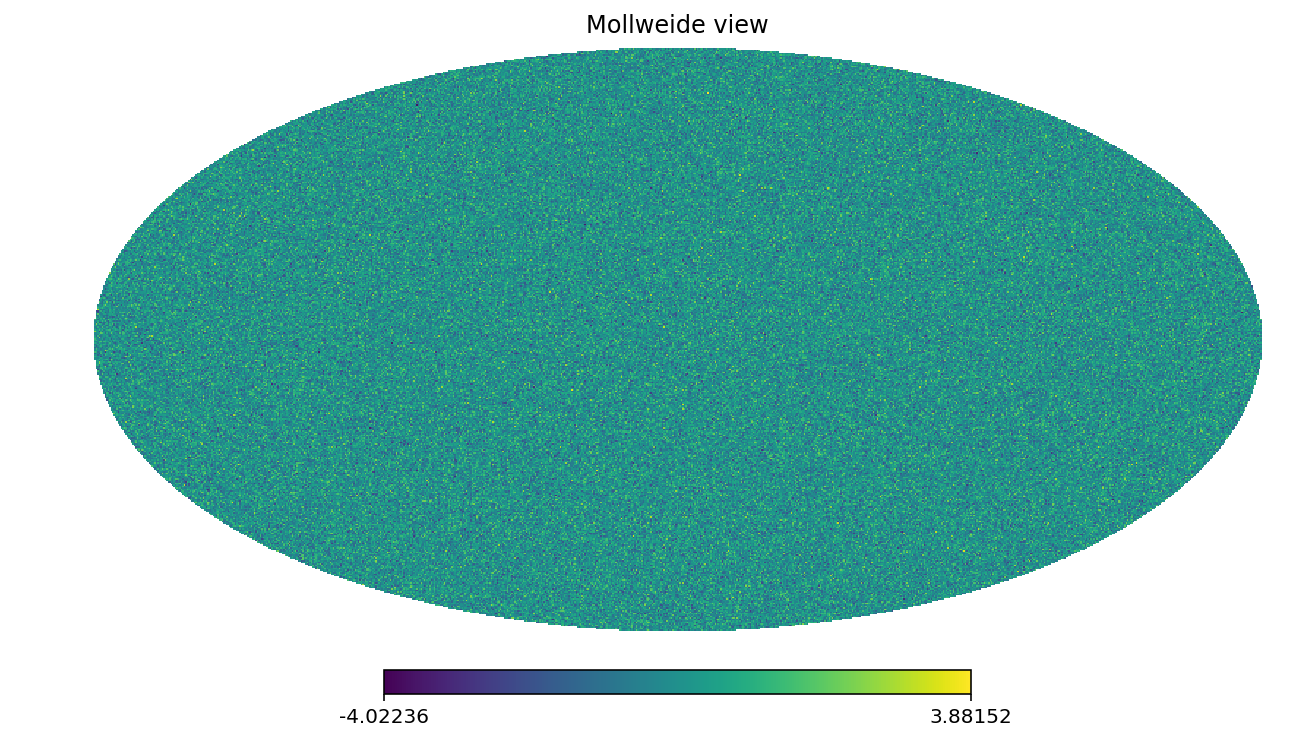

In [10]:
hp.mollview(sim.hpxmap_X)
hp.mollview(sim.hpxmap_Y)

## Load mask